# Test models (exponential and q)

## Import library

In [905]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr

## Setting up directory

In [906]:
data_dir = "/home/waves/projects/smap-drydown/data"
datarods_dir = "datarods"
SMAPL3_dir = r"SPL3SMP"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
PET_dir = r"PET"

import getpass
username = getpass.getuser()
formatted_now = datetime.now().strftime("%Y-%m-%d")
output_dir = rf"/home/waves/projects/smap-drydown/output/fit_models_nb_{username}_{formatted_now}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

## Read coordinate information and subset to CONUS

### Define the coordinates

In [907]:
file_path = os.path.join(data_dir, datarods_dir, "coord_info.csv")
coord_info = pd.read_csv(file_path)
file_path = os.path.join(data_dir, datarods_dir, "coord_open_water.csv")
coord_open_water = pd.read_csv(file_path)

min_lon = -125.000000
min_lat = 24.396308
max_lon = -66.934570
max_lat = 49.384358
_conus_subset = coord_info[(coord_info['latitude'] >= min_lat) &
                         (coord_info['latitude'] <= max_lat) &
                         (coord_info['longitude'] >= min_lon) &
                         (coord_info['longitude'] <= max_lon)].copy()

conus_subset = pd.merge(_conus_subset, coord_open_water, on=['EASE_row_index', 'EASE_column_index'], how='left', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
print(len(conus_subset))

9596


## Sample a point

id                   95641.000000
latitude                30.638416
EASE_row_index          99.000000
longitude             -103.257260
EASE_column_index      205.000000
Name: 7858, dtype: float64


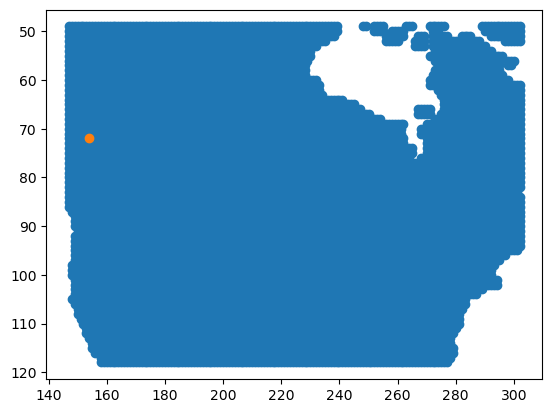

In [908]:
# SPECIFY THE INDEX (0, 9596)
p = 7000

# Plot the location
EASE_row_index = 72 #53 #72 #conus_subset.EASE_row_index.iloc[p].copy()
EASE_column_index = 154 #163 #154 #conus_subset.EASE_column_index.iloc[p].copy()
print(conus_subset.iloc[p])

# Plot 
plt.scatter(conus_subset.EASE_column_index, conus_subset.EASE_row_index)
plt.scatter(EASE_column_index, EASE_row_index)
ax = plt.gca()
ax.invert_yaxis()

## Load datasets

### SMAPL3 Soil mositure data

/home/waves/projects/smap-drydown/data/datarods/SPL3SMP/SPL3SMP_072_154.csv


,Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,Soil_Moisture_Retrieval_Data_AM_soil_moisture
time,,
2015-03-31,NaN,NaN
2015-04-01,0.114724,0.145578
2015-04-02,0.111474,NaN
2015-04-03,NaN,0.127666
2015-04-04,0.108182,NaN


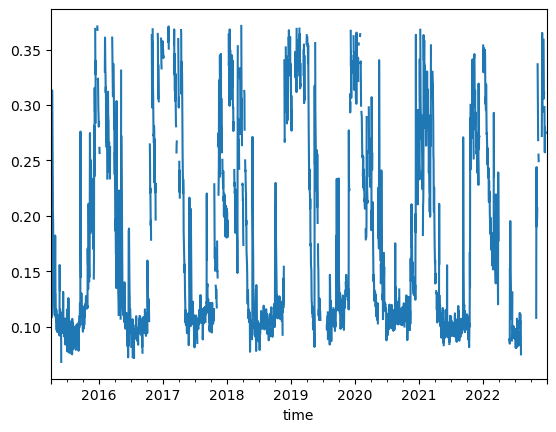

In [909]:
filename = os.path.join(data_dir, datarods_dir, SMAPL3_dir, f"SPL3SMP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
print(filename)
df = pd.read_csv(filename)

# Use retrieval flag to quality control the data
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
condition_bad_data_am = (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)
condition_bad_data_pm = (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)
df.loc[condition_bad_data_am, 'Soil_Moisture_Retrieval_Data_AM_soil_moisture'] = np.nan
df.loc[condition_bad_data_pm, 'Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'] = np.nan

# There is two different versions of 2015-03-31 data --- remove this 
duplicate_labels = df.index.duplicated(keep=False)
df = df.loc[~df.index.duplicated(keep='first')]

# Resample to regular time interval
df = df.resample('D').asfreq()

# Check if the data is all nan or not
df['Soil_Moisture_Retrieval_Data_AM_soil_moisture'].isna().all()

# Merge the AM and PM soil moisture data into one daily timeseries of data
df['soil_moisture_daily'] = df[['Soil_Moisture_Retrieval_Data_AM_soil_moisture','Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df.soil_moisture_daily.plot()

df[["Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm", "Soil_Moisture_Retrieval_Data_AM_soil_moisture"]].head()


### SMAPL4 Precipitation data

<Axes: xlabel='time'>

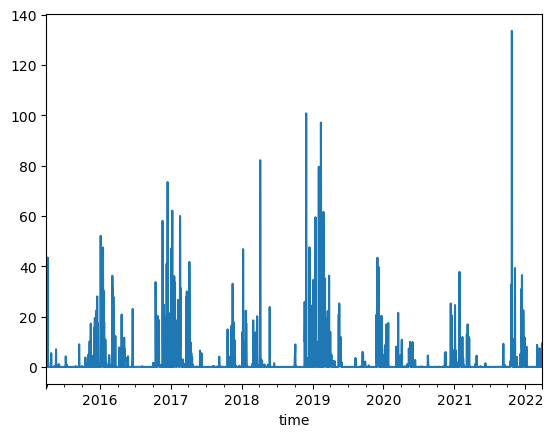

In [910]:
filename = os.path.join(data_dir, datarods_dir, SMAPL4_path, f"SPL4SMGP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
df_p = pd.read_csv(filename).drop(columns=['x','y']).rename({'precipitation_total_surface_flux': 'precip'}, axis='columns')
df_p['time'] = pd.to_datetime(df_p['time'])
df_p.set_index('time', inplace=True)

# Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
df_p.precip = df_p.precip * 86400

df_sync = pd.merge(df, df_p, how='inner', left_index=True, right_index=True)

df_sync['noprecip'] = df_sync['precip'] < 2 # < 0.00002 # Check this threshold 
df_sync['precip'].plot()

## Event separation

### Calculate dSdt

In [911]:
# Allow detecting soil moisture increment even if there is no SM data in between before/after rainfall event
df_sync['sm_for_dS_calc'] = df_sync['soil_moisture_daily'].ffill() 

# Maximum number of days of no data where dS/dt is calculated
fill_days = 3
# Calculate dS
df_sync['dS'] = df_sync['sm_for_dS_calc'].bfill(limit=fill_days).diff().where(df_sync['sm_for_dS_calc'].notnull()).replace(0, np.nan)

# Calculate dt
nan_counts = df_sync['dS'].isnull().astype(int).groupby(df_sync['dS'].notnull().cumsum()).cumsum().shift(1)
df_sync['dt'] = nan_counts.fillna(0).astype(int) + 1

# Calculate dS/dt
df_sync['dSdt'] = df_sync['dS']/df_sync['dt']
df_sync['dSdt'] = df_sync['dSdt']
df_sync.loc[df_sync['soil_moisture_daily'].isna(), 'dSdt'] = np.nan
df_sync['dSdt'] = df_sync['dSdt'].ffill(limit=fill_days)

df_sync[['soil_moisture_daily','precip','noprecip','sm_for_dS_calc','dS', 'dt', 'dSdt']].head()


,soil_moisture_daily,precip,noprecip,sm_for_dS_calc,dS,dt,dSdt
time,,,,,,,
2015-03-31,NaN,0.000000,True,NaN,NaN,1,NaN
2015-04-01,0.130151,0.000056,True,0.130151,NaN,2,NaN
2015-04-02,0.111474,0.000125,True,0.111474,-0.018677,3,-0.006226
2015-04-03,0.127666,0.000000,True,0.127666,0.016192,1,0.016192
2015-04-04,0.108182,0.000000,True,0.108182,-0.019484,1,-0.019484


### Detect significant peak

Adapt https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL072819


- To avoid noise truncating real drydowns, any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
- To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08). 
- Of the remaining drydowns, only those that contained more than four SMAP observations were retained.

Add more criteria in this paper 
- At least 3 data points are available during the first 4 days of drydowns
- Ignore data points where data points exceed theta_star definition (95% of the historical maximum soil moisture values)
- Following McMoll et al (2017) paper, we do not use rainfall data for detecting drydowns, as rainfall data has its own uncertainty

In [912]:
# Some empirical soil moisture signatures 
max_sm = df_sync.soil_moisture_daily.max()
min_sm = df_sync.soil_moisture_daily.min()
sm_range = max_sm - min_sm

# Ignore data points where data points exceed theta_star definition (95% of the historical maximum soil moisture values)
theta_star = max_sm * 0.95
# Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
noise_thresh = sm_range * 0.05

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
target_rmsd = 0.04
dSdt_thresh = target_rmsd * 2

print(f"Estimated theta_star is {theta_star:.2f}")
print(f"The preceding drydown should be dSdt > {dSdt_thresh:.2f}")
print(f"Drydown torelate the noise dSdt < {noise_thresh:.2f}")

Estimated theta_star is 0.35
The preceding drydown should be dSdt > 0.08
Drydown torelate the noise dSdt < 0.02


In [913]:
negative_increments = df_sync.dSdt < 0

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
positive_increments = df_sync.dSdt > dSdt_thresh

# TODO: NOT lose drydown starting after NaN

# Negative dSdt preceded with positive dSdt
df_sync['event_start'] = (negative_increments.shift(-1).fillna(False).astype(bool) & np.concatenate(([False], positive_increments[:-1])))
df_sync['event_start'][df_sync['event_start']].index

/tmp/ipykernel_547183/212533287.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sync['event_start'] = (negative_increments.shift(-1).fillna(False).astype(bool) & np.concatenate(([False], positive_increments[:-1])))


DatetimeIndex(['2015-04-09', '2015-09-18', '2015-11-10', '2016-04-11',
               '2016-05-07', '2016-05-08', '2016-06-20', '2017-06-01',
               '2017-06-09', '2017-09-08', '2017-11-22', '2018-05-27',
               '2019-05-17', '2019-09-20', '2019-10-01', '2019-11-28',
               '2020-03-09', '2020-03-10', '2020-04-06', '2020-05-19',
               '2020-06-01', '2020-12-27', '2021-01-06', '2021-01-28',
               '2021-04-27', '2021-09-11', '2021-12-08', '2022-03-05',
               '2022-03-17'],
              dtype='datetime64[ns]', name='time', freq=None)

### Adjust the event start if the previous data is nan

In [914]:
event_start_idx = df_sync['event_start'][df_sync['event_start']].index
for i, event_start_date in enumerate(event_start_idx):

    for j in range(0,fill_days+1): # Look back up to 3 timesteps to seek for sm value which is not nan, or start of the precip event
        current_date = event_start_date - pd.Timedelta(days=j)
        print(current_date)

        # If dSdt > 0 and SM value is not nan, use that
        if (df_sync.loc[current_date].dSdt > dSdt_thresh) & ~np.isnan(df_sync.loc[current_date].soil_moisture_daily):
            df_sync.loc[event_start_date, 'event_start']  = False
            df_sync.loc[current_date, 'event_start'] = True
            break

        if np.isnan(df_sync.loc[current_date].dSdt):
            break

    if event_start_date!=current_date:
        print(f"{event_start_date} replaced at {current_date}")

event_start_idx = np.isnan(df_sync["soil_moisture_daily"][df_sync['event_start']]).index
event_start_idx

2015-04-09 00:00:00
2015-04-08 00:00:00
2015-04-09 00:00:00 replaced at 2015-04-08 00:00:00
2015-09-18 00:00:00
2015-09-17 00:00:00
2015-09-18 00:00:00 replaced at 2015-09-17 00:00:00
2015-11-10 00:00:00
2015-11-09 00:00:00
2015-11-10 00:00:00 replaced at 2015-11-09 00:00:00
2016-04-11 00:00:00
2016-04-10 00:00:00
2016-04-11 00:00:00 replaced at 2016-04-10 00:00:00
2016-05-07 00:00:00
2016-05-06 00:00:00
2016-05-07 00:00:00 replaced at 2016-05-06 00:00:00
2016-05-08 00:00:00
2016-05-07 00:00:00
2016-05-06 00:00:00
2016-05-08 00:00:00 replaced at 2016-05-06 00:00:00
2016-06-20 00:00:00
2016-06-19 00:00:00
2016-06-18 00:00:00
2016-06-20 00:00:00 replaced at 2016-06-18 00:00:00
2017-06-01 00:00:00
2017-05-31 00:00:00
2017-06-01 00:00:00 replaced at 2017-05-31 00:00:00
2017-06-09 00:00:00
2017-06-08 00:00:00
2017-06-09 00:00:00 replaced at 2017-06-08 00:00:00
2017-09-08 00:00:00
2017-09-07 00:00:00
2017-09-08 00:00:00 replaced at 2017-09-07 00:00:00
2017-11-22 00:00:00
2017-11-21 00:00:00


DatetimeIndex(['2015-04-08', '2015-09-17', '2015-11-09', '2016-04-10',
               '2016-05-06', '2016-06-18', '2017-05-31', '2017-06-08',
               '2017-09-07', '2017-11-21', '2018-05-26', '2019-05-16',
               '2019-09-19', '2019-09-30', '2019-11-27', '2020-03-08',
               '2020-04-05', '2020-05-18', '2020-05-31', '2020-12-26',
               '2021-01-05', '2021-01-27', '2021-04-26', '2021-09-10',
               '2021-12-07', '2022-03-04', '2022-03-16'],
              dtype='datetime64[ns]', name='time', freq=None)

In [915]:
# event_start_idx_2 = pd.isna(df_sync["soil_moisture_daily"][df_sync['event_start']]).index
# for i, event_start_date in enumerate(event_start_idx_2):
#     update_date = event_start_date
#     for j in range(0,fill_days): # Look back up to 5 timesteps to seek for sm value which is not nan, or start of the precip event
#         current_date = event_start_date + pd.Timedelta(days=j)
#         if not pd.isna(df_sync.loc[current_date].soil_moisture_daily):
#             break

#     df_sync.loc[event_start_date, 'event_start']  = False
#     df_sync.loc[current_date, 'event_start'] = True
#     if event_start_date !=update_date:
#         print(f"{event_start_date} replaced at {update_date}")

In [916]:
# event_start_idx_3 = pd.isna(df_sync["soil_moisture_daily"][df_sync['event_start']]).index
# for i, event_start_date in enumerate(event_start_idx_3):
#     update_date = event_start_date
#     for j in range(0,fill_days): # Look back up to 5 timesteps to seek for sm value which is not nan, or start of the precip event
#         current_date = event_start_date + pd.Timedelta(days=j)

#         try:
#             if (df_sync.loc[current_date].soil_moisture_daily > theta_star):
#                 update_date = current_date
#                 break
#         except:
#             None

#     df_sync.loc[event_start_date, 'event_start']  = False
#     df_sync.loc[update_date, 'event_start'] = True
#     if event_start_date !=update_date:
#         print(f"{event_start_date} replaced at {update_date}")

In [917]:
df_sync["event_start"][df_sync["event_start"]].index

DatetimeIndex(['2015-04-08', '2015-09-17', '2015-11-09', '2016-04-10',
               '2016-05-06', '2016-06-18', '2017-05-31', '2017-06-08',
               '2017-09-07', '2017-11-21', '2018-05-26', '2019-05-16',
               '2019-09-19', '2019-09-30', '2019-11-27', '2020-03-08',
               '2020-04-05', '2020-05-18', '2020-05-31', '2020-12-26',
               '2021-01-05', '2021-01-27', '2021-04-26', '2021-09-10',
               '2021-12-07', '2022-03-04', '2022-03-16'],
              dtype='datetime64[ns]', name='time', freq=None)

### Iterate through each row to find event end

In [918]:
df_sync['event_end'] = np.zeros(len(df_sync), dtype=bool)
event_start_idx = df_sync['event_start'][df_sync['event_start']].index
record_last_date = df_sync.index.values[-1]
record_start_date = df_sync.index.values[0]
for i, event_start_date in enumerate(event_start_idx):
    print(f"processing {event_start_date}")
    remaining_records = record_last_date - event_start_date
    previous_records = event_start_date - record_start_date

    for j in range(1, remaining_records.days):
        current_date = event_start_date + pd.Timedelta(days=j)

        if (df_sync.loc[current_date].dSdt >= noise_thresh) & (~np.isnan(df_sync.loc[current_date].soil_moisture_daily)): 
            # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded (if there is not precipitation) if it would otherwise truncate a drydown. 
            update_date = current_date -  pd.Timedelta(days=1)
            df_sync.loc[update_date, 'event_end'] = True
            print(f"end reached at {update_date} (dSdt increment exceed the noise)")
            break
        else:
            None

        if (pd.isna(df_sync.loc[current_date].dSdt)): 
            # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded (if there is not precipitation) if it would otherwise truncate a drydown. 
            update_date = current_date -  pd.Timedelta(days=1)
            df_sync.loc[update_date, 'event_end'] = True
            print(f"end reached at {update_date} (dSdt nan data length is reached)")
            break  
        else:
            continue

# create a new column for event_end
df_sync['dSdt(t-1)'] = df_sync.dSdt.shift(+1)

processing 2015-04-08 00:00:00
end reached at 2015-04-23 00:00:00 (dSdt increment exceed the noise)
processing 2015-09-17 00:00:00
end reached at 2015-10-01 00:00:00 (dSdt increment exceed the noise)
processing 2015-11-09 00:00:00
end reached at 2015-11-09 00:00:00 (dSdt increment exceed the noise)
processing 2016-04-10 00:00:00
end reached at 2016-04-23 00:00:00 (dSdt increment exceed the noise)
processing 2016-05-06 00:00:00
end reached at 2016-05-20 00:00:00 (dSdt increment exceed the noise)
processing 2016-06-18 00:00:00
end reached at 2016-08-11 00:00:00 (dSdt increment exceed the noise)
processing 2017-05-31 00:00:00
end reached at 2017-06-07 00:00:00 (dSdt increment exceed the noise)
processing 2017-06-08 00:00:00
end reached at 2017-06-19 00:00:00 (dSdt increment exceed the noise)
processing 2017-09-07 00:00:00
end reached at 2017-10-19 00:00:00 (dSdt increment exceed the noise)
processing 2017-11-21 00:00:00
end reached at 2017-11-26 00:00:00 (dSdt increment exceed the noise)


In [919]:
df_sync[['soil_moisture_daily','precip','noprecip','sm_for_dS_calc','dS', 'dt', 'dSdt', 'event_start', 'event_end']]['2017-05-01':'2017-05-30']

,soil_moisture_daily,precip,noprecip,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end
time,,,,,,,,,
2017-05-01,0.163114,5.269687e-12,True,0.163114,-0.005079,1,-0.005079,False,False
2017-05-02,0.157446,1.168401e-08,True,0.157446,-0.005668,1,-0.005668,False,False
2017-05-03,0.148912,1.227785e-09,True,0.148912,-0.008534,1,-0.008534,False,False
2017-05-04,0.156290,3.862988e-13,True,0.156290,0.007377,1,0.007377,False,False
2017-05-05,0.137264,0.000000e+00,True,0.137264,-0.019026,1,-0.019026,False,False
2017-05-06,0.127370,0.000000e+00,True,0.127370,-0.009894,1,-0.009894,False,False
2017-05-07,0.122445,4.450624e-14,True,0.122445,-0.004925,1,-0.004925,False,False
2017-05-08,0.108597,5.092685e-19,True,0.108597,-0.013848,1,-0.013848,False,False
2017-05-09,0.103785,1.793485e-19,True,0.103785,-0.004812,1,-0.004812,False,False


### Remove data above theta_star

In [920]:
df_sync["sm_for_modelfit"] = df_sync['soil_moisture_daily'].where(df_sync['soil_moisture_daily'] <= theta_star)
sum(df_sync["sm_for_modelfit"] > theta_star)

0

### Get normalized SM

In [921]:
df_sync['normalized_S'] = (df_sync.sm_for_modelfit - min_sm)/(max_sm - min_sm)

### Plot

(16709.0, 17074.0)

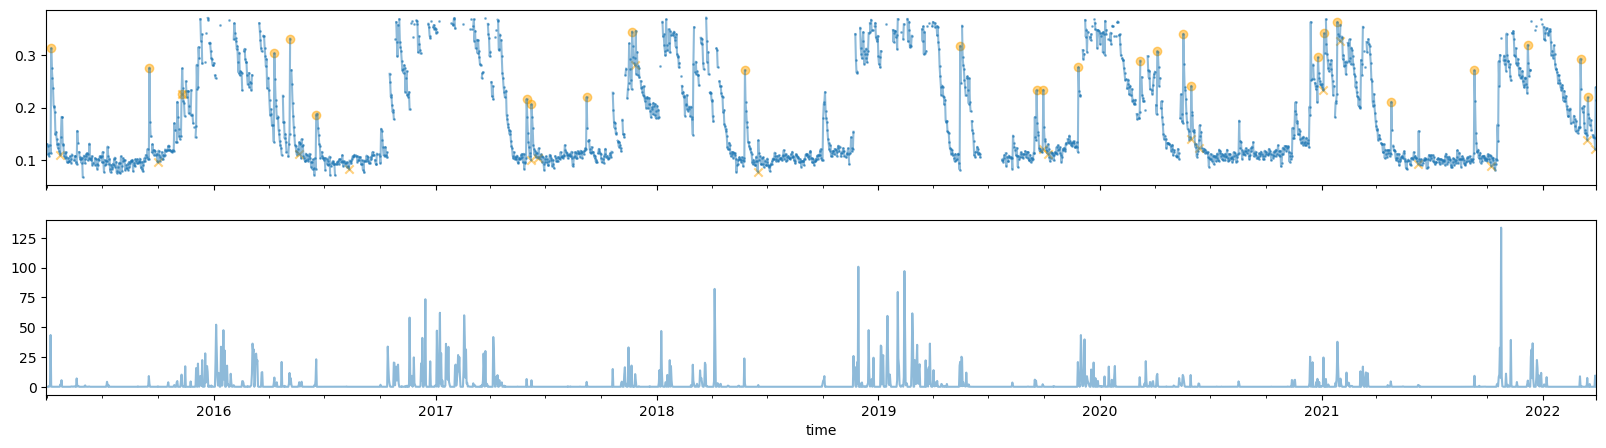

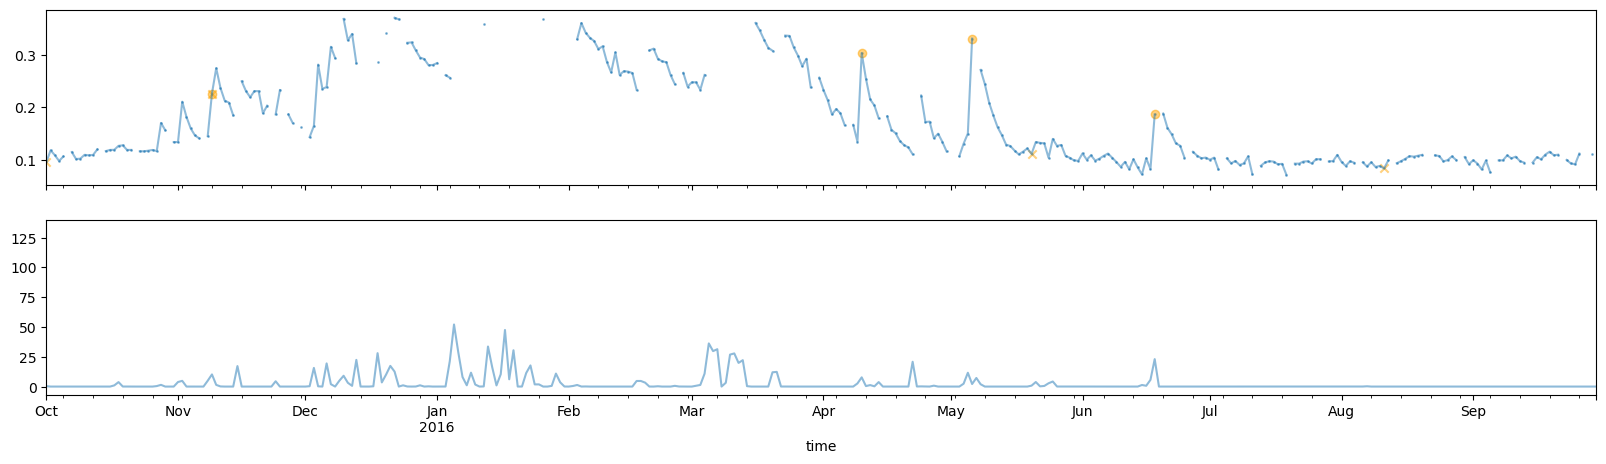

In [922]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ax11.scatter(df_sync.index, df_sync['soil_moisture_daily'], color='tab:blue', alpha=0.5, s=1)
df_sync.soil_moisture_daily.plot(ax=ax11,  color='tab:blue', alpha=0.5)
ax11.scatter(df_sync.index[df_sync['event_start']], df_sync['soil_moisture_daily'][df_sync['event_start']], color='orange', alpha=0.5)
ax11.scatter(df_sync.index[df_sync['event_end']], df_sync['soil_moisture_daily'][df_sync['event_end']], color='orange', marker='x', alpha=0.5)
# ax11.set_xlim('2019', '2020')
df_sync.precip.plot(ax=ax12, alpha=0.5)
fig.savefig(os.path.join(output_dir, f'pt_{EASE_row_index:03d}_{EASE_column_index:03d}_timeseries.png'))

fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ax21.scatter(df_sync.index, df_sync['soil_moisture_daily'], color='tab:blue', alpha=0.5, s=1)
df_sync.soil_moisture_daily.plot(ax=ax21, alpha=0.5 , color='tab:blue',)
ax21.scatter(df_sync.soil_moisture_daily[df_sync['event_start']].index, df_sync.soil_moisture_daily[df_sync['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(df_sync.soil_moisture_daily[df_sync['event_end']].index, df_sync.soil_moisture_daily[df_sync['event_end']].values, color='orange', marker='x', alpha=0.5)
df_sync.precip.plot(ax=ax22, alpha=0.5)

plot_year = 2015
ax22.set_xlim([datetime(plot_year, 10, 1), datetime(plot_year+1, 9, 30)])

## Check dataframe

In [923]:
df_sync[["soil_moisture_daily","dS", "dt","dSdt","event_start", "event_end"]]['2015-11-01':'2015-11-30']

,soil_moisture_daily,dS,dt,dSdt,event_start,event_end
time,,,,,,
2015-11-01,0.133994,-0.000060,1,-0.000060,False,False
2015-11-02,0.210947,0.076953,1,0.076953,False,False
2015-11-03,0.181922,-0.029025,1,-0.029025,False,False
2015-11-04,0.159901,-0.022021,1,-0.022021,False,False
2015-11-05,0.146553,-0.013348,1,-0.013348,False,False
2015-11-06,0.141142,-0.005411,1,-0.005411,False,False
2015-11-07,NaN,NaN,1,-0.005411,False,False
2015-11-08,0.145348,0.004206,2,0.002103,False,False
2015-11-09,0.226479,0.081131,1,0.081131,True,True


### Separate into events

In [924]:
start_indices = df_sync[df_sync['event_start']].index
end_indices = df_sync[df_sync['event_end']].index

# Create a new DataFrame with each row containing a list of soil moisture values between each pair of event_start and event_end
event_data = [{'event_start': start_index, 
               'event_end': end_index, 
               'sm': list(df_sync.loc[start_index:end_index, 'sm_for_modelfit'].values),
               'normalized_S': list(df_sync.loc[start_index:end_index, 'normalized_S'].values),
               'delta_theta': df_sync.loc[start_index, 'dSdt(t-1)'],
               } 
               for start_index, end_index in zip(start_indices, end_indices)]
event_df = pd.DataFrame(event_data)

min_consective_days = 4
event_df_long = event_df[event_df['sm'].apply(lambda x: pd.notna(x).sum()) >= min_consective_days].copy()
event_df_long = event_df_long.reset_index(drop=True)

# # Filtering condition
# min_consective_days_for_event_start = 3
# # Apply a filter to check the first 3 entries are not NaN
# event_df_long = event_df_long[event_df_long['sm'].apply(lambda x: pd.Series(x[:3]).notna().all())].copy()
# event_df_long = event_df_long.reset_index(drop=True)

## Fit models to drydown curve

### Calculate tau & q

In [925]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import minimize

### Expontnetial model

In [926]:
# # Function for exponential model
# def exp_model(t, delta_theta, theta_w, tau):
#     return delta_theta * np.exp(-t/tau) + theta_w

def exponential_model(t, delta_theta, theta_w, tau):
    """
    Calculate the drydown curve for soil moisture over time using non-linear plant stress model.

    Parameters:
        t (int): Timestep, in day.
        delta_theta (float): Shift/increment in soil moisture after precipitation, in m3/m3.
        theta_w (float, optional): Wilting point soil moisture content, equal to s_star * porosity, in m3/m3. Default is 0.0.
        tau (float): decay rate, in 1/day.

    Returns:
        float: Rate of change in soil moisture (dtheta/dt) for the given timestep, in m3/m3/day.

    Reference:
        McColl, K.A., W. Wang, B. Peng, R. Akbar, D.J. Short Gianotti, et al. 2017.
        Global characterization of surface soil moisture drydowns.
        Geophys. Res. Lett. 44(8): 3682–3690. doi: 10.1002/2017GL072819.
    """
    return delta_theta * np.exp(-t / tau) + theta_w

In [927]:
# Fit exponential model to each drydown event
opt_model = 'OLSE'
drydown_params = []

for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    sm_subset = np.asarray(row['normalized_S'])
    t = np.arange(0, len(sm_subset),1)
    min_norm_sm_subset = np.nanmin(sm_subset)
    max_norm_sm_subset = np.nanmax(sm_subset)
    sm_subset_range = max_norm_sm_subset - min_norm_sm_subset
    x = t[~np.isnan(sm_subset)]
    y = sm_subset[~np.isnan(sm_subset)]

    ### Delta_theta ###
    min_delta_theta = 0
    max_delta_theta = 1
    ini_delta_theta = sm_subset_range

    ### Theta_w ###
    min_theta_w = 0
    max_theta_w = min_norm_sm_subset
    ini_theta_w = (min_theta_w + max_theta_w) / 2

    ### Tau ###
    min_tau = 0
    max_tau = np.inf
    ini_tau = 1

    bounds = [
        (min_delta_theta, min_theta_w, min_tau),
        (max_delta_theta, max_theta_w, max_tau),
    ]
    p0 = [ini_delta_theta, ini_theta_w, ini_tau]

    try: 
        # Fit the data
        popt, pcov = curve_fit(f=exponential_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = exponential_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2], 'r_squared': r_squared, 'opt_drydown': y_opt.tolist()})
        
    except Exception as e:
        print("An error occurred:", e)
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()

,event_start,event_end,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2015-04-08,2015-04-23,0.753682,0.053214,6.727402,0.987130,"[0.8068962402836928, 0.7027933800164028, 0.613..."
1,2015-09-17,2015-10-01,0.553659,0.089920,1.882242,0.893611,"[0.6435790060600719, 0.4153893198096563, 0.281..."
2,2016-04-10,2016-04-23,0.615388,0.125715,4.882904,0.967579,"[0.7411035733051939, 0.6271418863693511, 0.534..."
3,2016-05-06,2016-05-20,0.842120,0.058556,5.269241,0.983050,"[0.9006764192507154, 0.634702439735307, 0.5351..."
4,2016-06-18,2016-08-11,0.289110,0.012312,18.472227,0.584461,"[0.30142158094913546, 0.27175447046538936, 0.2..."


In [928]:
event_df_with_curvefit = pd.merge(event_df_long, drydown_params_df.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit.head()

,event_start,event_end,sm,normalized_S,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2015-04-08,2015-04-23,"[0.31318346, 0.275290015, 0.25687596, 0.236819...","[0.8081865109415408, 0.6831342059450421, 0.622...",-0.014384,0.053214,6.727402,0.987130,"[0.8068962402836928, 0.7027933800164028, 0.613..."
1,2015-09-17,2015-10-01,"[0.2760191, 0.17227228, 0.14501567, nan, 0.115...","[0.6855402621848053, 0.34316497862172907, 0.25...",0.000596,0.089920,1.882242,0.893611,"[0.6435790060600719, 0.4153893198096563, 0.281..."
2,2016-04-10,2016-04-23,"[0.30355594, 0.254857445, 0.21518575, 0.203677...","[0.7764146948028949, 0.6157046023420363, 0.484...",-0.032042,0.125715,4.882904,0.967579,"[0.7411035733051939, 0.6271418863693511, 0.534..."
3,2016-05-06,2016-05-20,"[0.3310338, nan, 0.27150503, 0.2444901, 0.2092...","[0.8670944872939467, nan, 0.6706433622482716, ...",0.019295,0.058556,5.269241,0.983050,"[0.9006764192507154, 0.634702439735307, 0.5351..."
4,2016-06-18,2016-08-11,"[0.18654457, nan, 0.18834437, 0.16127484, 0.14...","[0.39026501827445725, nan, 0.39620454524363885...",-0.020491,0.012312,18.472227,0.584461,"[0.30142158094913546, 0.27175447046538936, 0.2..."


### q model

In [929]:
def q_model(t, k, q, delta_theta, theta_star=1.0, theta_w=0.0):
    """
    Calculate the drydown curve for soil moisture over time using non-linear plant stress model.

    Parameters:
        t (int): Timestep, in day.
        k (float): Product of soil thickness (z) and maximum rate of change in normalized soil moisture (k), equivalent to maximum ET rate (ETmax), in m3/m3/day.
        q (float): Degree of non-linearity in the soil moisture response.
        delta_theta (float): Shift/increment in soil moisture after precipitation, in m3/m3. It is equal to theta_0 - theta_w.
        theta_star (float, optional): Critical soil moisture content, equal to s_star * porosity, in m3/m3. Default is 1.0.
        theta_w (float, optional): Wilting point soil moisture content, equal to s_star * porosity, in m3/m3. Default is 0.0.

    Returns:
        float: Rate of change in soil moisture (dtheta/dt) for the given timestep, in m3/m3/day.
    """

    b = delta_theta ** (1 - q)

    a = (1 - q) / ((theta_star - theta_w) ** q)

    return (-k * a * t + b) ** (1 / (1 - q)) + theta_w

In [930]:
drydown_params = []
for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    sm_subset = np.asarray(row['normalized_S'])
    PET = 10 #np.average(row['PET']) # TODO: fix this as observed PET after getting the dataset
    t = np.arange(0, len(sm_subset),1)
    sm_subset_range = np.nanmax(sm_subset) - np.nanmin(sm_subset)
    sm_subset_min = np.nanmin(sm_subset)
    sm_subset_max = np.nanmax(sm_subset)
    x = t[~np.isnan(sm_subset)]
    y = sm_subset[~np.isnan(sm_subset)]
    
    # Define the bounds
    # q_model(t, k, q, delta_theta, theta_star, theta_w=0)
    # custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
    
    ### k (should be close to PET/z ###
    min_k = 0
    max_k = np.inf
    ini_k = 10

    ### q ###
    min_q = 0 #-np.inf
    max_q = np.inf
    ini_q = 1.0 + 1.0e-02

    ### delta_theta ###
    min_delta_theta = 0.0
    max_delta_theta = 1.0  # Equivalent of self.data.range_sm as the input theta values are normalized in this code
    ini_delta_theta = sm_subset_range

    bounds = [(min_k, min_q, min_delta_theta), (max_k, max_q, max_delta_theta)]
    p0 = [ini_k, ini_q, ini_delta_theta]
    
    try: 
        # Fit the model
        popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = q_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'q__k': popt[0], 'q__q': popt[1], 'q__delta_theta': popt[2], 'q__r_squared': r_squared, 'q__opt_drydown': y_opt.tolist()})

    except Exception as e:
        print("An error occurred:", e)
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()
event_df_with_curvefit = pd.merge(event_df_with_curvefit, drydown_params_df, on=['event_start', 'event_end'], how='outer')

### Plot and save

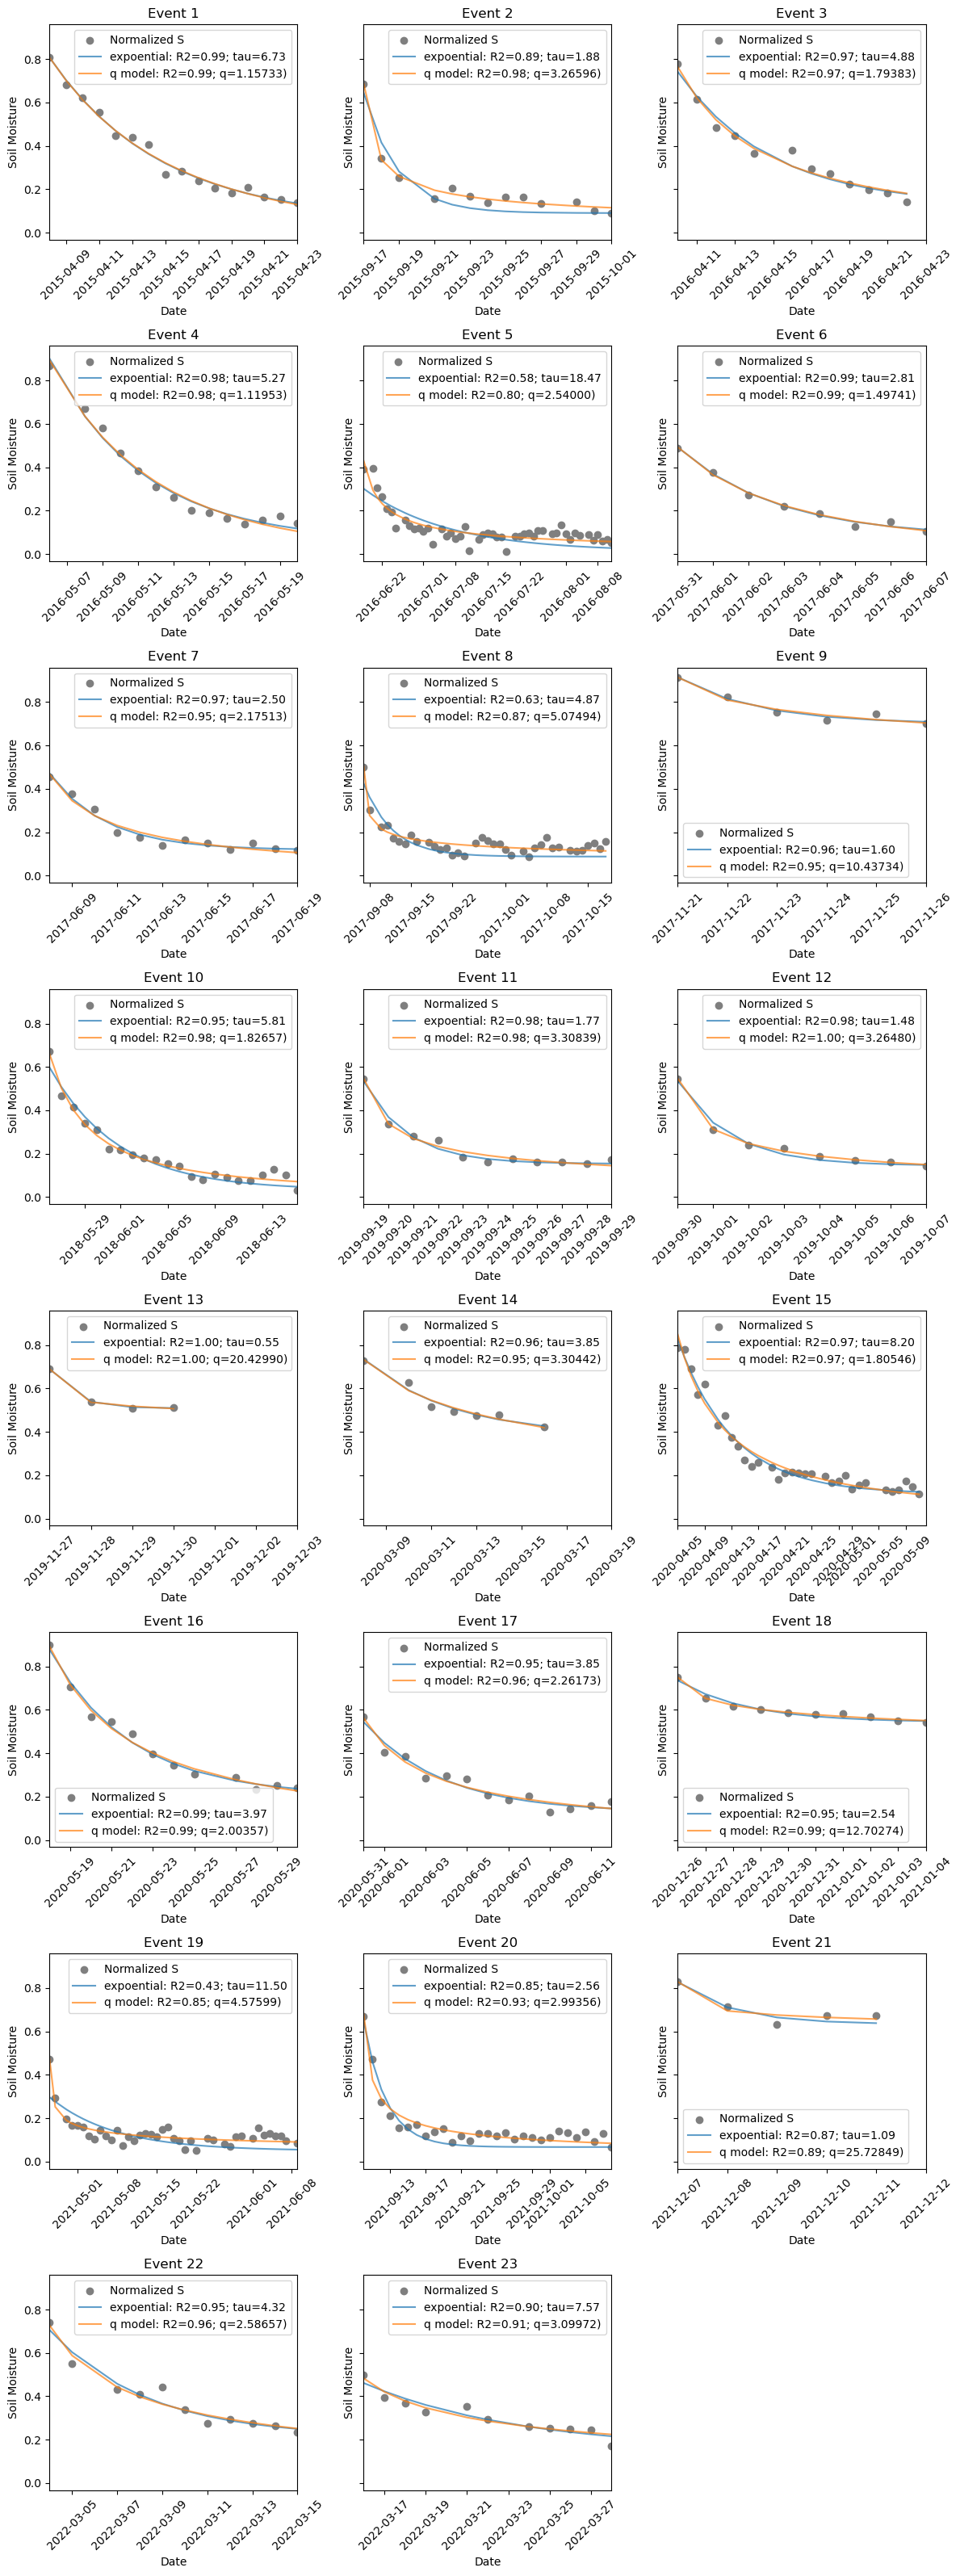

In [931]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 3
num_rows = (num_events + num_cols - 1) // num_cols  # This ensures an extra row if there's a remainder

# Plot each event as a time series
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=True, figsize=(12, 4 * num_rows))
axes = np.array(axes).reshape(num_rows, num_cols)  # Ensure axes is always 2D

for index, row in event_df_with_curvefit.iterrows():
    ax = axes[index // num_cols, index % num_cols]

    x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
    y = np.asarray(row['normalized_S'])
    y_opt = np.asarray(row['opt_drydown'])
    y_opt__q = np.asarray(row['q__opt_drydown'])
    r_squared = row['r_squared']
    q__r_squared = row['q__r_squared']
    q = row['q__q']
    tau = row['tau']

    ax.scatter(x, y, label='Normalized S', color='tab:grey')
    if ~np.all(np.isnan(y_opt)):
        ax.plot(x[~np.isnan(y)], y_opt, alpha=.7, label=f'expoential: R2={r_squared:.2f}; tau={tau:.2f}', color='tab:blue')
    if ~np.all(np.isnan(y_opt__q)):
        ax.plot(x[~np.isnan(y)], y_opt__q, alpha=.7, label=f'q model: R2={q__r_squared:.2f}; q={q:.5f})', color='tab:orange')

    ax.set_title(f'Event {index+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Soil Moisture')
    ax.set_xlim([row['event_start'], row['event_end']])
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Hide any unused axes
for ax in axes.flat[index+1:]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()

In [932]:
# row = event_df_long.iloc[1]

# # Read the data
# start_date = row['event_start']
# end_date = row['event_end']
# delta_theta = row['delta_theta']
# norm_S = row['normalized_S']
# sm_subset = np.asarray(row['normalized_S'])
# PET = 10 #np.average(row['PET']) # TODO: fix this as observed PET after getting the dataset
# t = np.arange(0, len(sm_subset),1)
# soil_moisture_range = np.nanmax(sm_subset) - np.nanmin(sm_subset)
# sm_subset_min = np.nanmin(sm_subset)
# sm_subset_max = np.nanmax(sm_subset)
# x = t[~np.isnan(sm_subset)]
# y = sm_subset[~np.isnan(sm_subset)]

# ############ exponential model ######################


# ############ q model ######################
# # Define the bounds
# # q_model(t, k, q, delta_theta, theta_star, theta_w=0)
# # custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
# epsilon = 1.0E-10
# bounds  = [(0., 0., 0., 0., 0), (PET*10, 10, 1., 1., 1.)]
# p0      = [PET, 1. + 1.E-03, soil_moisture_range, 0.5, 1.0E-5]

# # Fit the model
# popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
# # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
# # pcov: The estimated covariance of popt

# # Reroduce the analytical solution and calculate the residuals
# y_opt = q_model(x, *popt)
# residuals = y - y_opt
# ss_res = np.sum(residuals ** 2)
# ss_tot = np.sum((y - np.nanmean(y)) ** 2)
# r_squared = 1 - (ss_res / ss_tot)

# # Convert drydown parameters to DataFrame
# plt.scatter(x, y)
# plt.plot(x, y_opt)